In [42]:
import pandas as pd
train_df = pd.read_csv("D:/datathon/academy2025/train.csv")
print(train_df.info())
print(train_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tarih              227520 non-null  object 
 1   ürün               227520 non-null  object 
 2   ürün besin değeri  227520 non-null  int64  
 3   ürün kategorisi    227520 non-null  object 
 4   ürün fiyatı        227520 non-null  float64
 5   ürün üretim yeri   227520 non-null  object 
 6   market             227520 non-null  object 
 7   şehir              227520 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 13.9+ MB
None
       ürün besin değeri    ürün fiyatı
count      227520.000000  227520.000000
mean          143.113924      17.018837
std           133.218871      14.470524
min             8.000000       0.740000
25%            41.000000       7.380000
50%            83.000000      12.860000
75%           250.000000      21.630000
max         

In [43]:
test_df= pd.read_csv("D:/datathon/academy2025/testFeatures.csv")

In [44]:
def enrich_with_date_features(df):
    df["tarih"] = pd.to_datetime(df["tarih"])
    df["yıl"] = df["tarih"].dt.year
    df["ay"] = df["tarih"].dt.month
    df["hafta"] = df["tarih"].dt.isocalendar().week
    df["gün"] = df["tarih"].dt.day
    df["hafta_günü"] = df["tarih"].dt.dayofweek
    df["hafta_sonu"] = (df["hafta_günü"] >= 5).astype(int)
    return df


In [45]:
train_df = enrich_with_date_features(train_df)
test_df = enrich_with_date_features(test_df)


In [46]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['ürün', 'ürün kategorisi', 'ürün üretim yeri', 'market', 'şehir']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    encoders[col] = le  # Test'te aynı dönüşüm uygulanması için saklıyoruz


In [47]:
import numpy as np

train_df["fiyat_besin_oranı"] = train_df["ürün fiyatı"] / (train_df["ürün besin değeri"] + 1e-5)
train_df["log_fiyat"] = np.log1p(train_df["ürün fiyatı"])
train_df["log_besin"] = np.log1p(train_df["ürün besin değeri"])

test_df["fiyat_besin_oranı"] = np.nan  # test için yok çünkü 'ürün fiyatı' yok
test_df["log_besin"] = np.log1p(test_df["ürün besin değeri"])


In [48]:
# Ürün bazlı ortalama fiyat
urun_fiyat_avg = train_df.groupby("ürün")["ürün fiyatı"].mean().rename("ürün_ortalama_fiyatı")
train_df = train_df.join(urun_fiyat_avg, on="ürün")
test_df = test_df.join(urun_fiyat_avg, on="ürün")

# Şehir bazlı ortalama fiyat
sehir_fiyat_avg = train_df.groupby("şehir")["ürün fiyatı"].mean().rename("şehir_ortalama_fiyatı")
train_df = train_df.join(sehir_fiyat_avg, on="şehir")
test_df = test_df.join(sehir_fiyat_avg, on="şehir")

# Fark sütunları
train_df["fiyat_ürün_farkı"] = train_df["ürün fiyatı"] - train_df["ürün_ortalama_fiyatı"]


In [49]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tarih                  227520 non-null  datetime64[ns]
 1   ürün                   227520 non-null  int64         
 2   ürün besin değeri      227520 non-null  int64         
 3   ürün kategorisi        227520 non-null  int64         
 4   ürün fiyatı            227520 non-null  float64       
 5   ürün üretim yeri       227520 non-null  int64         
 6   market                 227520 non-null  int64         
 7   şehir                  227520 non-null  int64         
 8   yıl                    227520 non-null  int32         
 9   ay                     227520 non-null  int32         
 10  hafta                  227520 non-null  UInt32        
 11  gün                    227520 non-null  int32         
 12  hafta_günü             227520 non-null  int3

eda

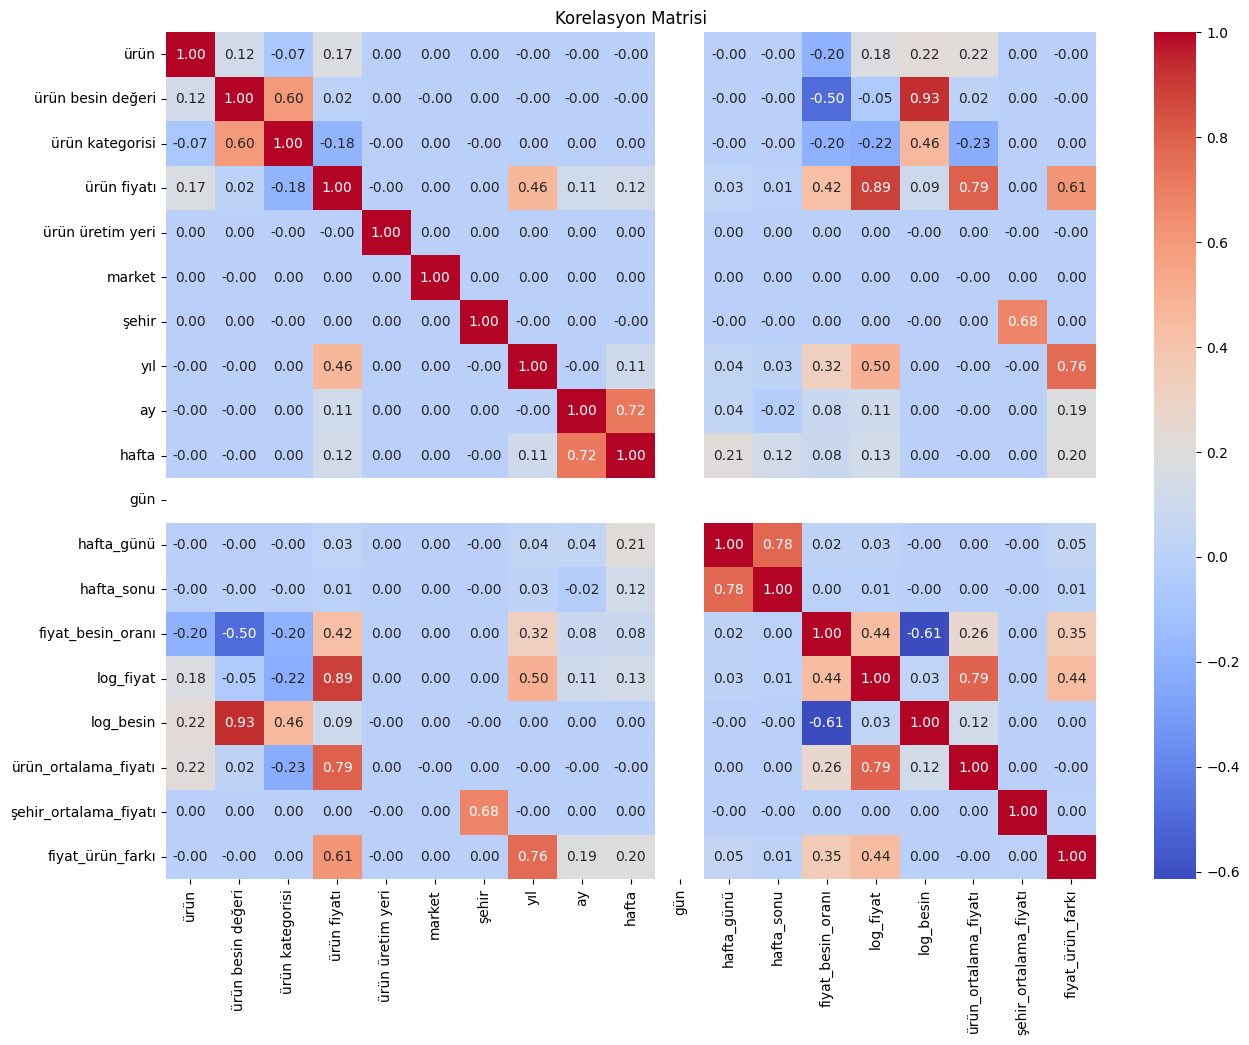

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 11))
#sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
sns.heatmap(train_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Korelasyon Matrisi")
plt.show()


In [51]:
# Sadece sayısal sütunlar
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns

# Ürün fiyatı ile korelasyonu olanları hesapla
correlations = train_df[numeric_cols].corr()["ürün fiyatı"]

# |korelasyon| < 0.01 olan sütunları al
low_corr_features = correlations[abs(correlations) < 0.01].index.tolist()
print("Düşük korelasyonlu sütunlar:", low_corr_features)


Düşük korelasyonlu sütunlar: ['ürün üretim yeri', 'market', 'şehir', 'hafta_sonu', 'şehir_ortalama_fiyatı']


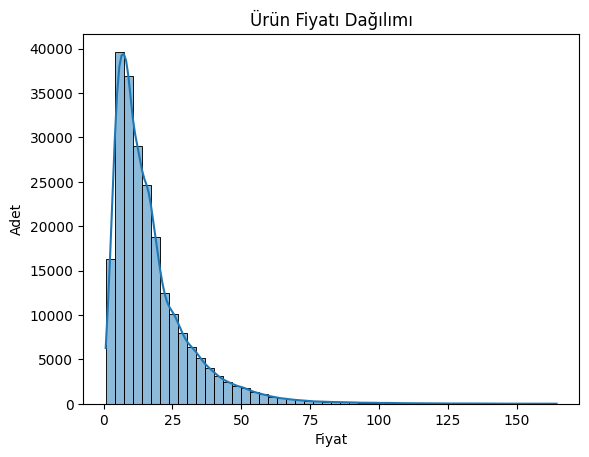

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df["ürün fiyatı"], bins=50, kde=True)
plt.title("Ürün Fiyatı Dağılımı")
plt.xlabel("Fiyat")
plt.ylabel("Adet")
plt.show()


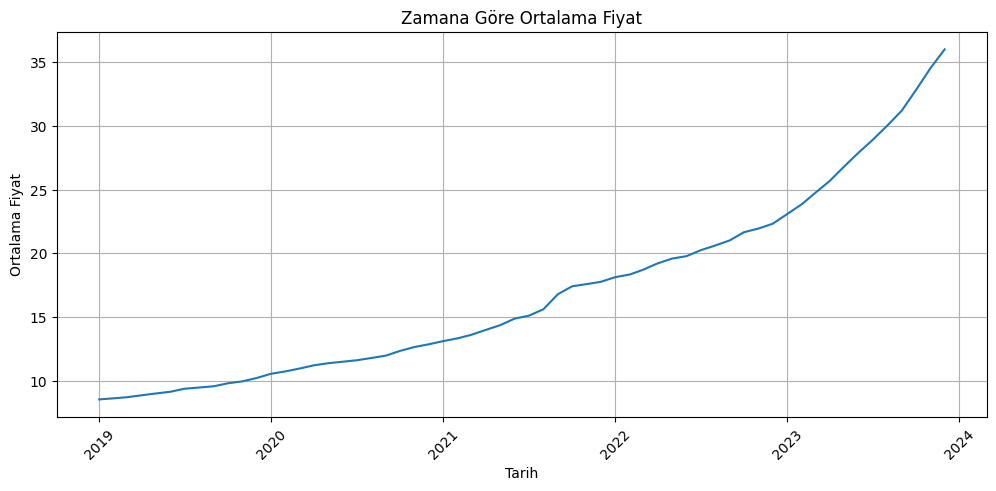

In [53]:
df_temp = train_df.groupby("tarih")["ürün fiyatı"].mean().reset_index()
plt.figure(figsize=(12, 5))
plt.plot(df_temp["tarih"], df_temp["ürün fiyatı"])
plt.title("Zamana Göre Ortalama Fiyat")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Fiyat")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [56]:
y = train_df["ürün fiyatı"]
X = train_df.drop(columns=["tarih", "ürün fiyatı", "gün"])


In [57]:
X = X.fillna(X.mean(numeric_only=True))


In [58]:
X = X.drop(columns=low_corr_features)

In [59]:
X

,ürün,ürün besin değeri,ürün kategorisi,yıl,ay,hafta,hafta_günü,fiyat_besin_oranı,log_fiyat,log_besin,ürün_ortalama_fiyatı,fiyat_ürün_farkı
0,65,120,0,2019,1,1,1,0.272500,3.517498,4.795791,66.331559,-33.631559
1,70,103,0,2019,1,1,1,0.107184,2.488234,4.644391,21.930622,-10.890622
2,61,160,0,2019,1,1,1,0.070000,2.501436,5.081404,22.621944,-11.421944
3,1,354,3,2019,1,1,1,0.019887,2.084429,5.872118,14.048236,-7.008236
4,2,72,3,2019,1,1,1,0.184444,2.658860,4.290459,26.430750,-13.150750
...,...,...,...,...,...,...,...,...,...,...,...,...
227515,59,110,1,2023,12,48,4,0.522818,4.069198,4.709530,28.226101,29.283899
227516,60,115,1,2023,12,48,4,0.610870,4.266195,4.753590,30.345847,39.904153
227517,62,100,1,2023,12,48,4,0.702100,4.265633,4.615121,31.729806,38.480194
227518,55,110,1,2023,12,48,4,0.571545,4.156850,4.709530,30.214014,32.655986
